In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import sys, os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import ray
import os
from sklearn.linear_model import LinearRegression

try:
    ray.init(log_to_driver=False)
except RuntimeError:
    ray.shutdown()
    ray.init(log_to_driver=False)
    
sys.path.append('../../src/')
# import toolbox
from toolbox import *

result_names = ['BBT_Tiingo',                #0
                'BBT_future_Tiingo_ada', 
                'BBT_future_Tiingo_eth',     #2
                'BBT_future_Tiingo_ltc',
                'BBT_future_Tiingo_xrp',     #4
                'BBT_future_BITX',
                'BBT_future_BITW20',         #6
                'BBT_future_BITW70', 
                'BBT_future_BITW100',        #8
                'BBT_future_CRIX']

risk_measures = ['Variance',
                 'ES q=0.05', 'ES q=0.01',
                 'VaR q=0.05', 'VaR q=0.01', 
                 'ERM k=10', 'CH']

order = ['BBT_Tiingo',    
         'BBT_future_CRIX',  'BBT_future_BITX', 'BBT_future_BITW100', 
         'BBT_future_BITW20',  'BBT_future_BITW70',
         'BBT_future_Tiingo_ada', 'BBT_future_Tiingo_eth',  'BBT_future_Tiingo_ltc','BBT_future_Tiingo_xrp']

coin_names = ['btc', 'CRIX', 'BITX', 'BITW100', 'BITW20', 'BITW70', 'ada', 'eth', 'ltc', 'xrp']


new_coin_names = ['BTC',  'CRIX',  'BITX', 'BITW100', 'BITW20', 'BITW70',
                  'ADA', 'ETH', 'LTC', 'XRP']

start = '2019-10-21'

In [2]:
# Stationary Block Bootstrap 2.7.2 of Lahiri
def SB(X, p, T, seed):
    np.random.seed(seed)
    # X: time series to be sampled
    # p: param of Geometric distribution; 1/p = mean of block sample length
    # T: length of pseudo time series    
    blockL = 0
    s = []
    while blockL < T:
        I = int(np.random.choice(len(X), 1, replace=True))
        L = int(np.random.geometric(p=p, size=1))
        _id = np.linspace(I, I+L-1, num=L)
        _id = (_id % len(X)).astype(int)
        blockL += len(_id)
        s.append(X.loc[_id, :])
    return pd.concat(s).iloc[:T]

@ray.remote(num_returns=1)
def SB_parallel(X, p, T, seed):
    return SB(X, p, T, seed)

In [3]:
ES5 = lambda x: ES(0.05, x)
ES1 = lambda x: ES(0.01, x)
VaR5 = lambda x: VaR(0.05, x)
VaR1 = lambda x: ES(0.01, x)
ERM = lambda x: ERM_estimate_trapezoidal(10, x)

risk_measure_arr = [Variance, ES5, ES1, VaR5, VaR1, ERM, Variance]
rm_dict = dict(zip(risk_measures, risk_measure_arr))
risk_measure_name = ['Variance', 'ES 95%', 'ES 99%', 'VaR 95%', 'VaR 99%', 'ERM', 'Variance']
rm2name =  dict(zip(risk_measures, risk_measure_name))
new_coin_names = coin_names = ['BTC', 'CRIX', 'BITX', 'BITW100', 'BITW20', 'BITW70', 'ADA', 'ETH', 'LTC', 'XRP']

0 Variance
1 ES q=0.05
2 ES q=0.01
3 VaR q=0.05
4 VaR q=0.01
5 ERM k=10


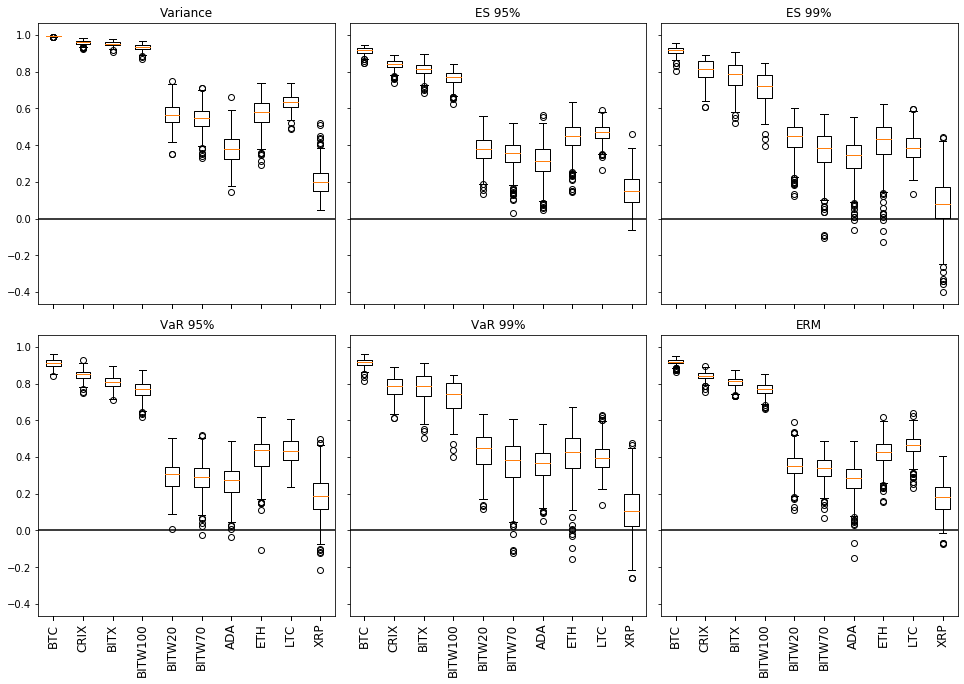

In [7]:
factor = 4.5
xsize = 3*factor
ysize = 2*factor
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(xsize, ysize), sharex=True, sharey=True)

N = 500 # number of samples
T = 300 # length of each sample
prob = 1/5
seed_arr = set(list(range(N)))

HE_outer2 = []
length_outer2 = []

for p, rm in enumerate(risk_measures[:-1]):
    print(p, rm)
    HE_outer = []
    length_outer = []
    
    risk_fn = rm_dict[rm]
    
    for q, rn in enumerate(order):
        if rm != 'CH':
            path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
            %(rn, rm)
        else:
            path = '../../results/%s/MM/rh_cross_hedge.csv'\
            %(rn)    
            
        _df = pd.read_csv(path)
        _df = _df.loc[_df.Date >= start,:] 
        
        samples = ray.get([SB_parallel.remote(_df,
                                              prob,
                                              T, 
                                              seed) for seed in seed_arr])

        HE = []
        length = []
        for s in samples:
            s = np.array(s.loc[:,['rh','rs']])
            risk_rh = risk_fn(s[:,0])
            risk_rs = risk_fn(s[:,1])
            HE.append(1-risk_rh/risk_rs)
            length.append(len(s))
            
        HE_outer.append(HE)
            
    HE_outer2.append(HE_outer)
    length_outer2.append(length_outer)

    if p<=2:
        axs[0, p].boxplot(HE_outer, showfliers=True)
        axs[0, p].set_title(rm2name[rm])
        axs[0, p].axhline(y=0, xmin=0, xmax=1, color='black')

    else:
        axs[1, p-3].boxplot(HE_outer, showfliers=True)
        axs[1, p-3].set_title(rm2name[rm], fontsize=12)
        axs[1, p-3].axhline(y=0, xmin=0, xmax=1, color='black')

plt.tight_layout()

for p, a in enumerate(axs):
    xtickNames = plt.setp(axs[p], xticklabels=new_coin_names)
    plt.setp(xtickNames, rotation=90, fontsize=12)
    
plt.savefig('HE_boxplot.pdf', transparent=True, bbox_inches='tight')

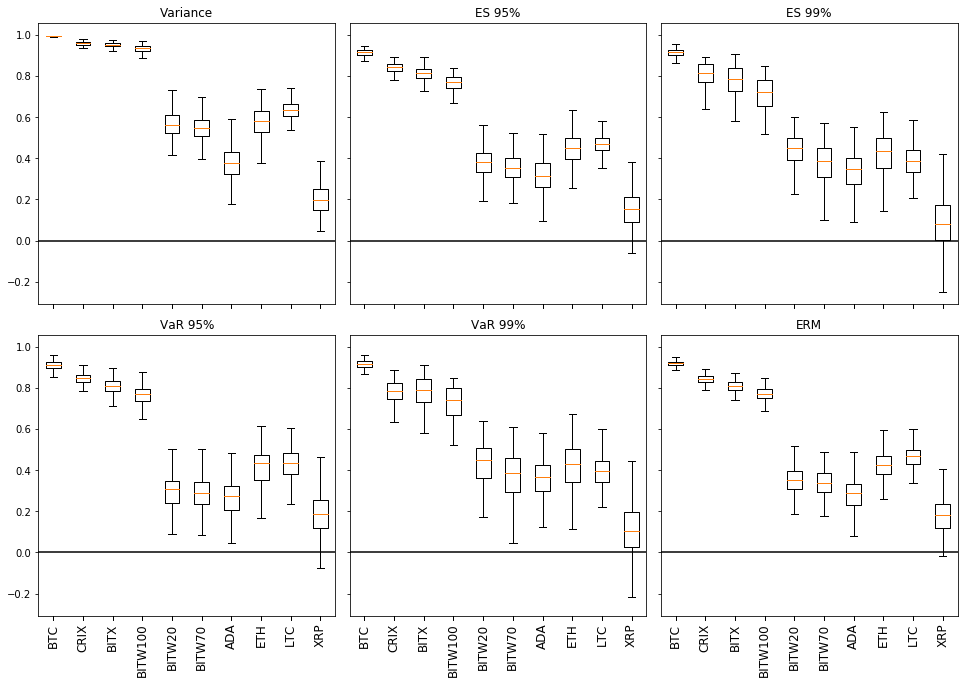

In [10]:
factor = 4.5
xsize = 3*factor
ysize = 2*factor
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(xsize, ysize), sharex=True, sharey=True)

N = 500 # number of samples
T = 300 # length of each sample
prob = 1/5
seed_arr = set(list(range(N)))

HE_outer2 = []
length_outer2 = []

for p, rm in enumerate(risk_measures[:-1]):
    HE_outer = []
    length_outer = []
    
    risk_fn = rm_dict[rm]
    
    for q, rn in enumerate(order):
        if rm != 'CH':
            path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
            %(rn, rm)
        else:
            path = '../../results/%s/MM/rh_cross_hedge.csv'\
            %(rn)    
            
        _df = pd.read_csv(path)
        _df = _df.loc[_df.Date >= start,:] 
        
        samples = ray.get([SB_parallel.remote(_df,
                                              prob,
                                              T, 
                                              seed) for seed in seed_arr])

        HE = []
        length = []
        for s in samples:
            s = np.array(s.loc[:,['rh','rs']])
            risk_rh = risk_fn(s[:,0])
            risk_rs = risk_fn(s[:,1])
            HE.append(1-risk_rh/risk_rs)
            length.append(len(s))
            
        HE_outer.append(HE)
            
    HE_outer2.append(HE_outer)
    length_outer2.append(length_outer)

    if p<=2:
        axs[0, p].boxplot(HE_outer, showfliers=False)
        axs[0, p].set_title(rm2name[rm])
        axs[0, p].axhline(y=0, xmin=0, xmax=1, color='black')

    else:
        axs[1, p-3].boxplot(HE_outer, showfliers=False)
        axs[1, p-3].set_title(rm2name[rm], fontsize=12)
        axs[1, p-3].axhline(y=0, xmin=0, xmax=1, color='black')

plt.tight_layout()

for p, a in enumerate(axs):
    xtickNames = plt.setp(axs[p], xticklabels=new_coin_names)
    plt.setp(xtickNames, rotation=90, fontsize=12)
    
plt.savefig('HE_boxplot2.pdf', transparent=True)